# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [95]:
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [111]:
connection = psycopg2.connect(database='human_resources',
                              user='readonly',
                              password='6hajV34RTQfmxhS',
                              host='dsstudents.skillbox.ru',
                              port=5432
                             )

In [47]:
# Гипотеза 1
# Есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник.

# выбираем всех менеджеров и считаем количество сотрудников, соответствующих разным perfomance score, кроме N/A- too early to review
# сортируем по имени менеджера, затем по perfomance score


sql_expression1 = '''
SELECT
    "Manager Name",
    "Performance Score",
    COUNT(*) AS employees_count
FROM 
    hr_dataset
GROUP BY
    "Manager Name",
    "Performance Score"
HAVING
    "Performance Score" 
    NOT LIKE 
    '%N/A%'
ORDER BY
    "Manager Name",
    "Performance Score"
'''

data1 = pd.read_sql(sql_expression1, connection)
data1

,Manager Name,Performance Score,employees_count
0,Alex Sweetwater,90-day meets,2
1,Alex Sweetwater,Exceeds,1
2,Alex Sweetwater,Exceptional,1
3,Alex Sweetwater,Fully Meets,4
4,Alex Sweetwater,Needs Improvement,1
...,...,...,...
69,Simon Roup,Fully Meets,6
70,Webster Butler,90-day meets,3
71,Webster Butler,Exceeds,2
72,Webster Butler,Fully Meets,11


In [48]:
# Гипотеза 1. Продолжение
# для каждого менеджера найдем самый частый Performance Score и количество сотрудников, соответсвующих ему

# сначала выбираем таблицу из запроса, записанного в data1
# в ней для каждого менеджера находим максимум столбца employees_count
# и по таблице с максимумами фильтруем исходную таблицу из data1, используя INNER JOIN
# сортируем по имени менеджера


sql_expression1_max = '''
SELECT 
    tbl.* 
FROM 
    (
     SELECT
         "Manager Name",
         "Performance Score",
         COUNT(*) AS employees_count
     FROM
         hr_dataset
     GROUP BY
         "Manager Name",
         "Performance Score"
     HAVING
         "Performance Score"
         NOT LIKE
         '%N/A%'
    )
AS tbl
INNER JOIN 
    (
     SELECT
         t."Manager Name",
         MAX(t.employees_count)
     FROM
         (
          SELECT
              "Manager Name",
              "Performance Score",
              COUNT(*) AS employees_count
          FROM
              hr_dataset
          GROUP BY
              "Manager Name",
              "Performance Score"
          HAVING
              "Performance Score"
              NOT LIKE
              '%N/A%'
         )
     AS t
     GROUP BY
         t."Manager Name"
    ) 
AS tbl2
ON 
    tbl2."Manager Name" = tbl."Manager Name" 
    AND 
    tbl2.max = tbl.employees_count
ORDER BY
    "Manager Name"
'''

data1_max = pd.read_sql(sql_expression1_max, connection)
data1_max

,Manager Name,Performance Score,employees_count
0,Alex Sweetwater,Fully Meets,4
1,Amy Dunn,Fully Meets,11
2,Board of Directors,Fully Meets,2
3,Brandon R. LeBlanc,Fully Meets,4
4,Brannon Miller,Fully Meets,8
5,Brian Champaigne,Fully Meets,8
6,David Stanley,Fully Meets,15
7,Debra Houlihan,Fully Meets,2
8,Elijiah Gray,Fully Meets,13
9,Eric Dougall,Fully Meets,3


В целом зависимость между perfomance score и тем, под чьим руководством работает сотрудник, не прослеживается.
***
***

In [94]:
# Гипотеза 1. Продолжение
# для каждого менеджера посчитаем количество сотрудников с Performance Score ниже и выше Fully Meets


# во вложеных подзапросах subq1, subq2 и subq3 считаем сотрудников по соответствующим Performance Score для каждого менеджера
# в подзапросе subq4 - общее число сотрудников для каждого менеджера, в подзапросе names - имена всех менеджеров
# после чего соединяяем все результаты, заменяя отсутвующие значения нулями
# считаем процентное соотношение сотрудников в разрезе каждого менеджера
# сортируем по имени менеджера


sql_expression1_pscomp = '''
SELECT 
    "Manager Name",
    COALESCE(employees_under_fmeets, 0) AS employees_under_fmeets,
    COALESCE(employees_above_fmeets, 0) AS employees_above_fmeets,
    COALESCE(employees_fmeets, 0) AS employees_fmeets,
    employees_total,
    (COALESCE(employees_under_fmeets, 0) * 100) / employees_total AS percent_under_fmeets,
    (COALESCE(employees_above_fmeets, 0) * 100) / employees_total AS percent_above_fmeets,
    (COALESCE(employees_fmeets, 0) * 100) / employees_total AS percent_fmeets
FROM
    (
     SELECT
         "Manager Name",
         COUNT(*) AS employees_under_fmeets
     FROM 
         hr_dataset
     WHERE "Performance Score" IN (
                                   SELECT bad."Performance Score"
                                   FROM 
                                       (
                                        SELECT 
                                            distinct perf_scoreid,
                                            "Performance Score"
                                        FROM
                                            hr_dataset
                                        WHERE "Performance Score" NOT LIKE '%N/A%'
                                        ORDER BY 
                                            perf_scoreid
                                        LIMIT 3
                                       )
                                   AS bad
                                  )
     GROUP BY
         "Manager Name"
    )
AS subq1
FULL JOIN
    (
     SELECT
         "Manager Name",
         COUNT(*) AS employees_above_fmeets
     FROM 
         hr_dataset
     WHERE "Performance Score" NOT IN (
                                       SELECT good."Performance Score"
                                       FROM 
                                           (
                                            SELECT 
                                                distinct perf_scoreid,
                                                "Performance Score"
                                            FROM
                                                hr_dataset
                                            WHERE "Performance Score" NOT LIKE '%N/A%'
                                            ORDER BY 
                                                perf_scoreid
                                            LIMIT 4
                                           )
                                       AS good
                                      )
     GROUP BY
         "Manager Name"
    )
AS subq2
USING("Manager Name")
FULL JOIN
    (
     SELECT
         "Manager Name",
         COUNT(*) AS employees_fmeets
     FROM 
         hr_dataset
     WHERE "Performance Score" 
         LIKE '%Fully Meets%'
     GROUP BY
         "Manager Name"
    )
AS subq3
USING("Manager Name")
FULL JOIN
    (
     SELECT
         "Manager Name",
         COUNT(*) AS employees_total
     FROM 
         hr_dataset
     GROUP BY
         "Manager Name"
    )
AS subq4
USING("Manager Name")
FULL JOIN
    (
     SELECT DISTINCT
         "Manager Name"
     FROM 
         hr_dataset
    ) 
AS names
USING("Manager Name")
ORDER BY
    percent_under_fmeets DESC
'''

data1_pscomp = pd.read_sql(sql_expression1_pscomp, connection)
data1_pscomp

,Manager Name,employees_under_fmeets,employees_above_fmeets,employees_fmeets,employees_total,percent_under_fmeets,percent_above_fmeets,percent_fmeets
0,Debra Houlihan,1,0,2,3,33,0,66
1,Alex Sweetwater,3,2,4,9,33,22,44
2,Simon Roup,5,6,6,17,29,35,35
3,Brannon Miller,6,7,8,21,28,33,38
4,Webster Butler,5,5,11,21,23,23,52
5,Michael Albert,5,8,9,22,22,36,40
6,Kissy Sullivan,5,3,14,22,22,13,63
7,John Smith,3,0,11,14,21,0,78
8,Peter Monroe,3,5,6,14,21,35,42
9,Elijiah Gray,4,5,13,22,18,22,59


Можно выделить менеджера Brian Champaigne - под его руководством сотрудники полностью соответсвуют должности, но при этом нет выдающихся.

При этом под руководсвом John Smith работает наибольший процент не соответствующих должности сотрудников при полном отсутствии выдающихся (Debra Houlihan не рассматриваем из-за малого общего количества подчиненных)

***
***

In [98]:
# Гипотеза 2
# Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.

# для каждого семейного положения посчитаем среднюю и медианную продолжительность работы
# сгруппируем таблицу по семейному положению, для каждой группы применим аггрегатную функцию с округлением


sql_expression2 = '''
SELECT
    "maritaldesc",
    ROUND(AVG("Days Employed")) AS average_d_employed,
    ROUND(MEDIAN("Days Employed")) AS median_d_employed
FROM
    hr_dataset
GROUP BY
    "maritaldesc"
'''

data2 = pd.read_sql(sql_expression2, connection)
data2

,maritaldesc,average_d_employed,median_d_employed
0,Widowed,863.0,1063.0
1,Married,1246.0,1154.0
2,Separated,1703.0,1497.0
3,Single,1373.0,1318.0
4,Divorced,1103.0,1084.0


<AxesSubplot:xlabel='maritaldesc', ylabel='median_d_employed'>

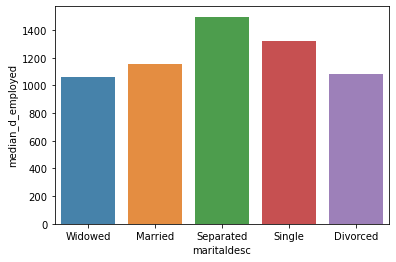

In [100]:
sns.barplot(x=data2['maritaldesc'], 
            y=data2['median_d_employed'],
            dodge=False, 
            alpha=0.9)

Из графика видно, что дольше всего работают одинокие сотрудники и сотрудники, состоящие в браке но живущие раздельно.
Меньше всего - овдовевшие и разведенные.

***
***

In [120]:
# Гипотеза 3
# Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

# для каждого возраста посчитаем минимальную, максимальную, среднюю и медианную продолжительность работы, используя аггрегатные функции
# сортируем по возрасту


sql_expression3 = '''
SELECT 
    age,
    MIN("Days Employed") AS min_d_employed,
    MAX("Days Employed") AS max_d_employed,
    ROUND(AVG("Days Employed")) AS average_d_employed,
    ROUND(MEDIAN("Days Employed")) AS median_d_employed
FROM
    hr_dataset
GROUP BY
    age
ORDER BY
    age
'''

data3 = pd.read_sql(sql_expression3, connection)
data3

,age,min_d_employed,max_d_employed,average_d_employed,median_d_employed
0,25,1476,2211,1844.0,1844.0
1,26,794,905,850.0,850.0
2,27,439,2428,1547.0,1560.0
3,28,57,2092,963.0,993.0
4,29,8,3611,1626.0,1476.0
5,30,127,3317,1094.0,940.0
6,31,6,2336,1200.0,1154.0
7,32,58,2645,1309.0,1205.0
8,33,19,1954,1059.0,1154.0
9,34,124,2386,1098.0,972.0


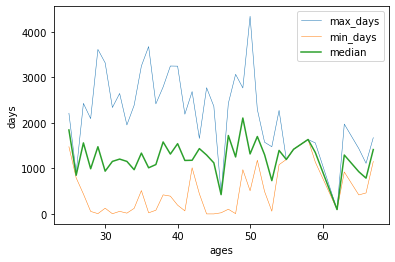

In [126]:
plt.plot(data3['age'], data3['max_d_employed'], label='max_days', linewidth=0.5)  
plt.plot(data3['age'], data3['min_d_employed'], label='min_days', linewidth=0.5)
plt.plot(data3['age'], data3['median_d_employed'], label='median', linewidth=1.5)
plt.xlabel('ages')
plt.ylabel('days')
plt.legend()
plt.show()

Медианная продолжительность работы в общем колеблется по всем возрастам в районе 1000 дней, с общей тенденцией к небольшому снижению с увеличением возраста.
***
***

In [63]:
# Гипотеза 4
# Есть зависимость между perfomance score и возрастом сотрудника.

# проверить продуктивность по возрасту
# сформируем группы по возрасту и для каждой группы найдем средний perfomance score
# поскольку столбцы с аггрегатными функциями нельзя использовать в JOIN, используем вложенный подзапрос
# разбиваем сотрудников на группы по возрасту, для каждой группы считаем средний perfomance score
# из основной таблицы выбираем все уникальные perfomance score id и соответсвующие им описания
# соединяем две полученные таблицы по perfomance score id и среднему perfomance score
# сортируем по возрастным группам


sql_expression4 = '''
SELECT
    t.age_range,
    ps."Performance Score" AS avg_perf_score 
FROM 
    (
     SELECT
         ROUND(AVG(perf_scoreid)) AS avg_score,
         CASE 
             WHEN (age >= 20) AND (age < 30) 
             THEN 'age 20-30' 
             WHEN (age >= 30) AND (age < 45) 
             THEN 'age 30-45' 
             WHEN (age >= 45) AND (age < 60) 
             THEN 'age 45-60' 
             ELSE 'age 60+' 
         END AS age_range 
     FROM
         hr_dataset
     GROUP BY
         age_range
    )
AS t 
LEFT JOIN 
    (
     SELECT
         distinct perf_scoreid,
         "Performance Score" 
     FROM
         hr_dataset 
     ORDER BY
         perf_scoreid
    ) 
AS ps 
ON 
    t.avg_score = ps.perf_scoreid 
ORDER BY
    age_range
'''

data4 = pd.read_sql(sql_expression4, connection)
data4

,age_range,avg_perf_score
0,age 20-30,Exceeds
1,age 30-45,Fully Meets
2,age 45-60,Fully Meets
3,age 60+,Fully Meets


In [67]:
# Гипотеза 4. Продолжение.

# Есть зависимость между perfomance score и возрастом сотрудника.

# более корректным кажется вариант с поиском наиболее часто встречающегося значения perfomance score для каждой возрастной группы

# сформируем группы по возрасту и для каждой группы найдем средний perfomance score
# поскольку столбцы с аггрегатными функциями нельзя использовать в JOIN, используем вложенный подзапрос
# разбиваем сотрудников на группы по возрасту, для каждой группы считаем количество каждого perfomance score
# вложенным запросом находим в каждой группе чаще всего встречающийся perfomance score
# и на основании него фильтруем основной запрос
# сортируем по возрастным группам


sql_expression4_count = '''
SELECT
    CASE
        WHEN (age >= 20) AND (age<30) 
        THEN 'age 20-30' 
        WHEN (age >= 30) AND (age<45) 
        THEN 'age 30-45'
        WHEN (age >= 45) AND (age<60) 
        THEN 'age 45-60'
        ELSE 'age 60+'
    END AS age_range,
    "Performance Score",
    COUNT("Performance Score")
FROM
    hr_dataset
GROUP BY 
    "Performance Score", 
    age_range
HAVING 
    COUNT("Performance Score") 
IN 
    (
     SELECT 
         MAX(count)
     FROM
         (
          SELECT
              CASE
                  WHEN (age >= 20) AND (age<30) 
                  THEN 'age 20-30' 
                  WHEN (age >= 30) AND (age<45) 
                  THEN 'age 30-45'
                  WHEN (age >= 45) AND (age<60) 
                  THEN 'age 45-60'
                  ELSE 'age 60+'
              END AS age_range,
          "Performance Score",
          COUNT("Performance Score")
          FROM
              hr_dataset
          GROUP BY 
              "Performance Score", 
              age_range
         ) AS t
     GROUP BY 
         t.age_range
    )
ORDER BY
    age_range
'''

data4_count = pd.read_sql(sql_expression4_count, connection)
data4_count

,age_range,Performance Score,count
0,age 20-30,Fully Meets,20
1,age 30-45,Fully Meets,111
2,age 45-60,Fully Meets,41
3,age 60+,Fully Meets,9


В целом сотрудники соответствуют занимаемым должностям, независимо от их возраста
***
***

In [61]:
# Гипотеза 5
# Есть зависимость между ставкой оплаты и расой сотрудника.

# проверить возможную дискриминацию по расе в части оплаты труда
# группируем таблицу по должностям и расам, для каждой группы считаем среднюю часову ставку оплаты, 
# сравниваем ее со средней ставкой из штатного расписания для каждой должности
# формируем столбец с результатом сравнения
# сортируем по названию должности


sql_expression5 = '''
SELECT 
    "position",
    "racedesc",
    AVG("Pay Rate") AS average_payrate,
    "Hourly Mid",
    CASE 
        WHEN (AVG("Pay Rate") < "Hourly Mid") 
        THEN 'lower' 
        ELSE 'higher'
    END AS average_compare2_hourly
FROM
    hr_dataset
INNER JOIN
    salary_grid
ON
    hr_dataset."position" = salary_grid."Position"
GROUP BY
    "position",
    "racedesc",
    "Hourly Mid"
ORDER BY 
    "position"
'''

data5 = pd.read_sql(sql_expression5, connection)
data5

,position,racedesc,average_payrate,Hourly Mid,average_compare2_hourly
0,Accountant I,Black or African American,25.750000,24.72,higher
1,Accountant I,White,29.000000,24.72,higher
2,Administrative Assistant,Asian,20.500000,19.23,higher
3,Administrative Assistant,White,19.030000,19.23,lower
4,Database Administrator,Asian,41.375000,32.84,higher
5,Database Administrator,Black or African American,40.199999,32.84,higher
6,Database Administrator,White,38.731250,32.84,higher
7,Network Engineer,White,39.677778,32.14,higher
8,Production Technician I,American Indian or Alaska Native,16.000000,19.23,lower
9,Production Technician I,Asian,19.262500,19.23,higher


В целом зависимость между расой и оплатой труда не прослеживается. На всех должностях оплата сотрудников примерно одинаковая, независимо от расы.

Есть общая тенденция по ряду должностей в оплате труда, например на должности Sr. Accountant у всех отрудников оплата ниже среднего (согласно штатного расписания)

***
***

In [91]:
# Гипотеза 6
# Есть зависимость между Performance Score и общими затратами на привлечение сотрудников из каждого канала.

# можно посмотреть, какие каналы привлечения приносят наиболее продуктивных сотрудников при наименьших затратах
# а может быть на какие-то каналы очень большие затраты, при этом сотрудники из этих каналов непродуктивны?


sql_expression6 = '''
SELECT
    "Employee Source",
    COALESCE("Total", 0) AS total_costs,
--    COALESCE(employees_under_fmeets, 0) AS employees_under_fmeets,
--    COALESCE(employees_fmeets_andabove, 0) AS employees_fmeets_andabove,
    employees_total,
    COALESCE("Total", 0) / employees_total AS costs_per_empl,
    (COALESCE(employees_under_fmeets, 0) * 100) / employees_total AS percent_under_fmeets,
    (COALESCE(employees_fmeets_andabove, 0) * 100) / employees_total AS percent_fmeets_andabove
FROM
    (
     SELECT
         "Employee Source",
         COUNT(*) AS employees_under_fmeets
     FROM 
         hr_dataset
     WHERE "Performance Score" IN (
                                   SELECT bad."Performance Score"
                                   FROM 
                                       (
                                        SELECT 
                                            distinct perf_scoreid,
                                            "Performance Score"
                                        FROM
                                            hr_dataset
                                        WHERE "Performance Score" NOT LIKE '%N/A%'
                                        ORDER BY 
                                            perf_scoreid
                                        LIMIT 3
                                       )
                                   AS bad
                                  )
     GROUP BY
         "Employee Source"
    )
AS subq1
FULL JOIN
    (
     SELECT
         "Employee Source",
         COUNT(*) AS employees_fmeets_andabove
     FROM 
         hr_dataset
     WHERE "Performance Score" NOT IN (
                                       SELECT good."Performance Score"
                                       FROM 
                                           (
                                            SELECT 
                                                distinct perf_scoreid,
                                                "Performance Score"
                                            FROM
                                                hr_dataset
                                            WHERE "Performance Score" NOT LIKE '%N/A%'
                                            ORDER BY 
                                                perf_scoreid
                                            LIMIT 3
                                           )
                                       AS good
                                      )
     GROUP BY
         "Employee Source"
    )
AS subq2
USING("Employee Source")
FULL join
recruiting_costs AS rc
ON "Employee Source" = rc."Employment Source"
FULL JOIN
    (
     SELECT
         "Employee Source",
         COUNT(*) AS employees_total
     FROM
         hr_dataset
     GROUP BY "Employee Source"
    )
AS total
USING("Employee Source")
ORDER BY
    costs_per_empl,
    percent_under_fmeets,
    percent_fmeets_andabove DESC
'''

data6 = pd.read_sql(sql_expression6, connection)
data6

,Employee Source,total_costs,employees_total,costs_per_empl,percent_under_fmeets,percent_fmeets_andabove
0,Information Session,0,4,0,0,100
1,Indeed,0,8,0,0,100
2,Company Intranet - Partner,0,1,0,0,100
3,On-line Web application,0,1,0,0,100
4,Vendor Referral,0,15,0,13,86
5,Employee Referral,0,31,0,16,83
6,Internet Search,0,6,0,16,83
7,Glassdoor,0,14,0,21,78
8,Word of Mouth,0,13,0,23,76
9,Professional Society,1200,20,60,10,90


Исходя из наших критериев оценки, лучшими каналами поиска сотрудников являются бесплатные. При этом можно считать лучшим бесплатным каналом можно считать Employee Referral, через него привлечено максимальное количество сотрудников с низким процентом низкопродуктивных сотрудников.

Также видно что через каналы Other, Website Banner Ads, Social Networks приходит больше всего непродуктивных сотрудников - более четверти всех сотрудников, пришедших из этих каналов, не соответсвуют занимаемым должностям (оценка ниже Fully Meets)
***
***